In [1]:
#!pip install python-dotenv jupysql clickhouse-connect numpy pandas matplotlib

In [1]:
#from datetime import datetime, timezone
import json
import os
import sys

import clickhouse_connect as chc
import dotenv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
#import seaborn as sns # Pretty plots

### Utils functions

In [2]:
def boxplot(ax, data, showDeadline=False):
    # Grid y only
    ax.grid(which='both', axis='x', linestyle='-', zorder=-10)
    ax.set_axisbelow(True)
    
    flierprops = dict(marker='o', zorder=-1, alpha=0.4, markersize=2,
                  markerfacecolor='None', markerfacecoloralt='None', markeredgecolor='orange')
    ax.boxplot(data, orientation='horizontal', whis=(5,99), flierprops=flierprops)

    for p in [95]:
        ax.boxplot(data, orientation='horizontal', whis=(5, p),
                    showbox=False, showfliers=False, manage_ticks=False,
                    whiskerprops={'alpha': 0}, medianprops={'alpha': 0})

    if showDeadline:
        # Highlight the 4s attestation deadline
        ax.axvline(x=4000, color='red', linestyle='--')
        #ax.annotate('Deadline', xy=(360, -2), xytext=(390, -28), xycoords='axes points', arrowprops=dict(facecolor='black', arrowstyle='->'))

def saveFig(filename):
    filepath = f"""{DIR_FIG}/{filename}.png"""
    plt.savefig(filepath, format="png", bbox_inches='tight', pad_inches=0.01)
    #plt.close()
    print(f"""Saved figure in {filepath}""")

### Global variables to modify

In [5]:
FILE_CREDENTIALS = '.ethpandas_xatu_credentials.env'

# Queries on the main database
file_suffix    = '1w'
QUERY_START_MS = '2025-10-01 00:00:00.000'
QUERY_END_MS   = '2025-10-08 00:00:00.000'

#file_suffix    = 'debug'
#QUERY_START_MS = '2025-10-01 00:00:00.000'
#QUERY_END_MS   = '2025-10-01 00:30:00.000'

### devnet5: 2025-10-10 > 2025-10-17 but there was bug for most of it, only leaving 12h of data
### https://ethpandaops.io/posts/fusaka-devnet-5-bpo-analysis
DEVNET5 = True
if DEVNET5:
    file_suffix    = 'devnet5'
    QUERY_START_MS = '2025-09-17 18:00:00.000'
    QUERY_END_MS   = '2025-10-19 00:00:00.000'

QUERY_START_S = QUERY_START_MS[:-4]
QUERY_END_S = QUERY_END_MS[:-4]
QUERY_START_D = QUERY_START_MS[:-13]
QUERY_END_D = QUERY_END_MS[:-13]

DIR_DATA = 'data'
DIR_FIG = 'fig'

FILE_BLOCKS = f"""{DIR_DATA}/blocks_{file_suffix}.parquet"""
FILE_LATENCIES = f"""{DIR_DATA}/latencies_{file_suffix}.parquet"""
FILE_BLOBS = f"""{DIR_DATA}/blobs_{file_suffix}.parquet"""
FILE_ATTESTATIONS = f"""{DIR_DATA}/attestations_{file_suffix}.parquet"""

# Create directories if needed
for dir in (DIR_DATA, DIR_FIG):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print('Created directory ' + dir)

### Setup clickhouse connection

In [6]:
# Connections and credentials for xatu clickhouses
if not os.path.exists(FILE_CREDENTIALS) or os.getenv('XATU_PASSWORD') == 'TODO':
    print('Expected a file containing the credentials for ethpandasops Xatu in ' + FILE_CREDENTIALS)

dotenv.load_dotenv(FILE_CREDENTIALS)

# Different clickhouse domains for mainnet+testnets vs devnets
clickhouse_cfg = {}
clickhouse_cfg['main'] = {
    'domain': 'clickhouse.xatu.ethpandaops.io',
    'user': os.getenv('XATU_USERNAME'),
    'pw': os.getenv('XATU_PASSWORD')
}
clickhouse_cfg['exp'] = {
    'domain': 'clickhouse.xatu-experimental.ethpandaops.io',
    'user': os.getenv('XATU_EXPERIMENTAL_USERNAME'),
    'pw': os.getenv('XATU_EXPERIMENTAL_PASSWORD')
}

cfg = clickhouse_cfg['main']
if DEVNET5:
    cfg = clickhouse_cfg['exp']
client = chc.get_client(interface='https', host=cfg['domain'], port=443, user=cfg['user'], password=cfg['pw'])
print('Connected to ' + cfg['domain'])

# Remove remnants of devnet3 data in the main database
NETWORK_FILTER = 'meta_network_name != \'fusaka-devnet-3\''
if DEVNET5:
    NETWORK_FILTER = 'meta_network_name == \'fusaka-devnet-5\''

Connected to clickhouse.xatu-experimental.ethpandaops.io


# Queries

### Query: sanity check: is there data?

In [7]:
query = f"""
    SELECT
        meta_network_name,
        COUNT(DISTINCT meta_client_name) as unique_clients,
        COUNT(DISTINCT slot) as unique_slots
    FROM beacon_api_eth_v1_events_block_gossip
    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
    GROUP BY meta_network_name
    ORDER BY unique_slots DESC
"""

df = client.query_df(query)
print(df)
df = None

  meta_network_name  unique_clients  unique_slots
0   fusaka-devnet-3              82        205992
1   fusaka-devnet-5             135         14611
2    fusaka-holsf-0               6         11804
3    fusaka-holsf-1               6          6289
4    fusaka-sepsf-0               6          2385


### Query: finalized blocks

In [6]:
query = f"""
    SELECT
        meta_network_name as network, slot, block_root, execution_payload_transactions_total_bytes as total_payload_bytes
    FROM canonical_beacon_block FINAL
    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND {NETWORK_FILTER}
    ORDER BY slot ASC
"""

print('Querying canonical blocks... ', end='')
df = client.query_df(query)
print('done')
print(df.groupby('network').count())

df.to_parquet(FILE_BLOCKS, index=False)
print('Stored query results in ' + FILE_BLOCKS)
df = None

Querying canonical blocks... done
          slot  block_root  total_payload_bytes
network                                        
holesky  39755       39755                39755
hoodi    45691       45691                45691
mainnet  50077       50077                50077
sepolia  49137       49137                49137
Stored query results in data/blocks_1w.parquet


## Query: block discovery latency

In [16]:
### Table of pre-aggregated data is unavailable
#query = f"""
#    SELECT
#        slot, block_root, slot_start_date_time, seen_slot_start_diff, source
#    FROM mainnet.fct_block_first_seen_by_node FINAL
#    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#    ORDER by slot ASC
#"""

filter_high_latency = 30*1000 # Remove outliers above 30s eg due to from bugs

query = f"""
    SELECT
        meta_network_name as network, slot, block as block_root, meta_client_name as client,
        MIN(propagation_slot_start_diff) as block_latency
    FROM beacon_api_eth_v1_events_block_gossip FINAL
    WHERE event_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND propagation_slot_start_diff < {filter_high_latency}
        AND {NETWORK_FILTER}
    GROUP BY meta_network_name, slot, block, meta_client_name
    ORDER BY slot ASC
"""

print('Querying block latencies... ', end='')
df = client.query_df(query)
print('done')
print(df.groupby('network').count())

# Ensure the latencies are for blocks that have been finalized to avoid bad blocks
df_blocks = pd.read_parquet(FILE_BLOCKS)
df = pd.merge(df_blocks, df, on=['network', 'slot', 'block_root'], how='left')

df.to_parquet(FILE_LATENCIES, index=False)
print('Stored query results in ' + FILE_LATENCIES)
df = None
df_blocks = None

Querying block latencies... done
            slot  block_root   client  block_latency
network                                             
holesky  1468567     1468567  1468567        1468567
hoodi     441251      441251   441251         441251
mainnet  4346193     4346193  4346193        4346193
sepolia   394171      394171   394171         394171
Stored query results in data/latencies_1w.parquet


## Query: blob count and blob size

In [17]:
### Sparse data for Holesky up to 2025-10-25: 10 days of additional data but no blob sizes though :(
#_query2 = f"""
#    SELECT
#        meta_network_name as network, slot, block_root, COUNT(DISTINCT blob_index) as blob_count
#    FROM beacon_api_eth_v1_events_blob_sidecar FINAL
#    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#      AND meta_network_name = 'fusaka-devnet-5'
#    GROUP BY meta_network_name, slot, block_root
#    ORDER by slot ASC
#"""

### Full data for Holesky up to 2025-10-15
query = f"""
    SELECT
        meta_network_name as network, slot, block_root,
        COUNT(blob_index) as blob_count,
        SUM(blob_size) as total_blob_size
    FROM canonical_beacon_blob_sidecar FINAL
    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
      AND {NETWORK_FILTER}
    GROUP BY meta_network_name, slot, block_root
    ORDER BY slot ASC
"""

print('Querying blob data... ', end='')
df = client.query_df(query)
print('done')

if DEVNET5:
    # Block roots don't match across tables for devnet5 so it can't be used for joining tables
    df = df.drop(labels=['block_root'], axis=1)
else:
    # Only keep blobs relevant to the finalized chain
    df_blocks = pd.read_parquet(FILE_BLOCKS)
    df = pd.merge(df_blocks, df, on=['network', 'slot', 'block_root'], how='inner')

#print(df)
print(df.groupby('network').count())

df.to_parquet(FILE_BLOBS, index=False)
print('Stored query results in ' + FILE_BLOBS)
df = None
df_blocks = None

Querying blob data... done
          slot  block_root  total_payload_bytes  blob_count  total_blob_size
network                                                                     
holesky  18633       18633                18633       18633            18633
hoodi    43074       43074                43074       43074            43074
mainnet  44677       44677                44677       44677            44677
sepolia  48787       48787                48787       48787            48787
Stored query results in data/blobs_1w.parquet


## Query: attestation rate

In [36]:
### Unavailable table but would be ideal because pre-aggregated
#query = f"""
#    SELECT
#        slot, block_root, votes_head, votes_max
#    FROM mainnet.fct_attestation_correctness_canonical FINAL
#    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#    ORDER by slot ASC
#"""

### Get the committee size per slot
query_com = f"""
    SELECT
        meta_network_name as network, slot,
        SUM(arrayUniq(arrayConcat(validators))) as total_validators,
        COUNT(DISTINCT committee_index) as total_committees
    FROM canonical_beacon_committee FINAL
    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
      AND {NETWORK_FILTER}
    GROUP BY meta_network_name, slot
    ORDER BY slot ASC
"""

### Using arrayJoin() is a really good way to make the memory go to the moon
#query_att = f"""
#    SELECT
#        meta_network_name as network, slot, beacon_block_root as block_root,
#        COUNT(DISTINCT arrayJoin(validators)) as attested_validators,
#        COUNT(DISTINCT committee_index) as attested_committees
#    FROM canonical_beacon_elaborated_attestation FINAL
#    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#      AND {NETWORK_FILTER}
#    GROUP BY meta_network_name, slot, beacon_block_root
#    ORDER by slot ASC
#"""
# COUNT(DISTINCT arrayJoin(validators)) as attested_validators,
# SUM(length(arrayUnion(validators))) as attested_validators
# SUM(length(validators)) as attested_validators,

### Get the voters' size per slot
### This query is faster but a bit less precise (less than 0.0003 witnessed difference)
query_att = f"""
    SELECT
        s.meta_network_name as network, s.slot, s.beacon_block_root as block_root,
        SUM(s.attested_validators_per_committee) as attested_validators,
        COUNT(DISTINCT s.committee_index) as attested_committees
    FROM (
        SELECT
            meta_network_name, slot, beacon_block_root, committee_index,
            argMax(length(validators), length(validators)) as attested_validators_per_committee
        FROM canonical_beacon_elaborated_attestation FINAL
        WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
          AND {NETWORK_FILTER}
        GROUP BY meta_network_name, slot, beacon_block_root, committee_index
        ORDER BY slot ASC
    ) as s
    GROUP BY s.meta_network_name, s.slot, s.beacon_block_root
    ORDER BY slot ASC
"""

print('Querying committees... ', end='')
df_com = client.query_df(query_com)
print('done')
print('Querying attestations... ', end='')
df_att = client.query_df(query_att)
print('done')

# Only consider attestations relevant to the finalized chain
df_blocks = pd.read_parquet(FILE_BLOCKS)
df = pd.merge(df_blocks, df_com, on=['network', 'slot'], how='left')
df = pd.merge(df, df_att, on=['network', 'slot', 'block_root'], how='left')

#print(df.groupby('network').count())
print(df)

df.to_parquet(FILE_ATTESTATIONS, index=False)
print("Stored query results in " + FILE_ATTESTATIONS)
df = None
df_com = None
df_att = None
df_blocks = None

Querying committees... done
Querying attestations... done
        network      slot                                         block_root  \
0         hoodi   1421950  b'0xfc181e9bddd2378aecb1c110a622eb9cbc5e51a90c...   
1         hoodi   1421951  b'0x44e9795583ba73e2482eb1b93406abb1fb1a4762dd...   
2         hoodi   1421952  b'0x5d2c09e05649a635d36d7ee6832cf3a7dbb25c4ba0...   
3         hoodi   1421953  b'0x11fc856fa6c2ff3db66633f767d5f8a6094ce071b3...   
4         hoodi   1421954  b'0x074391e9539f24721e68d0b4ccabc3ef59a8246bb3...   
...         ...       ...                                                ...   
184655  mainnet  12754794  b'0x95b58ec4bef21409910e5732638fda7af78f23c148...   
184656  mainnet  12754795  b'0xd53e4049c2aaf6574ae3fde6e72cd3326b620a6524...   
184657  mainnet  12754796  b'0x06b21697f7006cb1f86b6ce046211933e3ab7c26cc...   
184658  mainnet  12754797  b'0x93c8ebdafa1f821a8fe19b2de8ac9f12071ae7c8e9...   
184659  mainnet  12754798  b'0xf80ae04ddce4770627eb2afea97b166

# Plots

## Plot: block discovery latency per network

Saved figure in ./blocks-networks.png


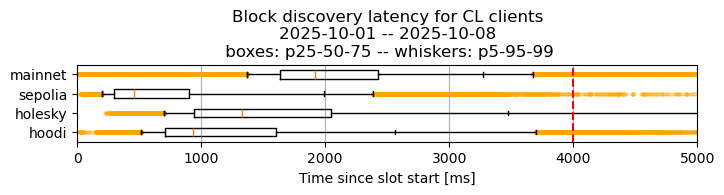

In [37]:
df_latencies = pd.read_parquet(FILE_LATENCIES)
#df_latencies.describe()

# Rearrange the data for easy plotting
data = {}
networks = df_latencies['network'].unique()
for i in networks:
    data[i] = df_latencies[ df_latencies['network'] == i ]['block_latency'].reset_index(drop=True)
    data[i] = data[i].dropna()
    data[i] = data[i].rename(i).rename_axis(i)
df_latencies = None

fig, ax = plt.subplots(1, 1, figsize=(8,1))

boxplot(ax, [data[i] for i in networks], showDeadline=True)

ax.set_xlim(0, 5*1000)

ax.set_xlabel('Time since slot start [ms]')
ax.set_yticklabels(networks)
ax.set_title('Block discovery latency for CL clients'
             + f"""\n{QUERY_START_D} -- {QUERY_END_D}"""
             + '\n boxes: p25-50-75 -- whiskers: p5-95-99'
            )

saveFig('blocks-networks')
plt.show()
data = None

## Plot: block discovery latency vs blob count

Saved figure in fig/blobs-fusaka-devnet-5.png


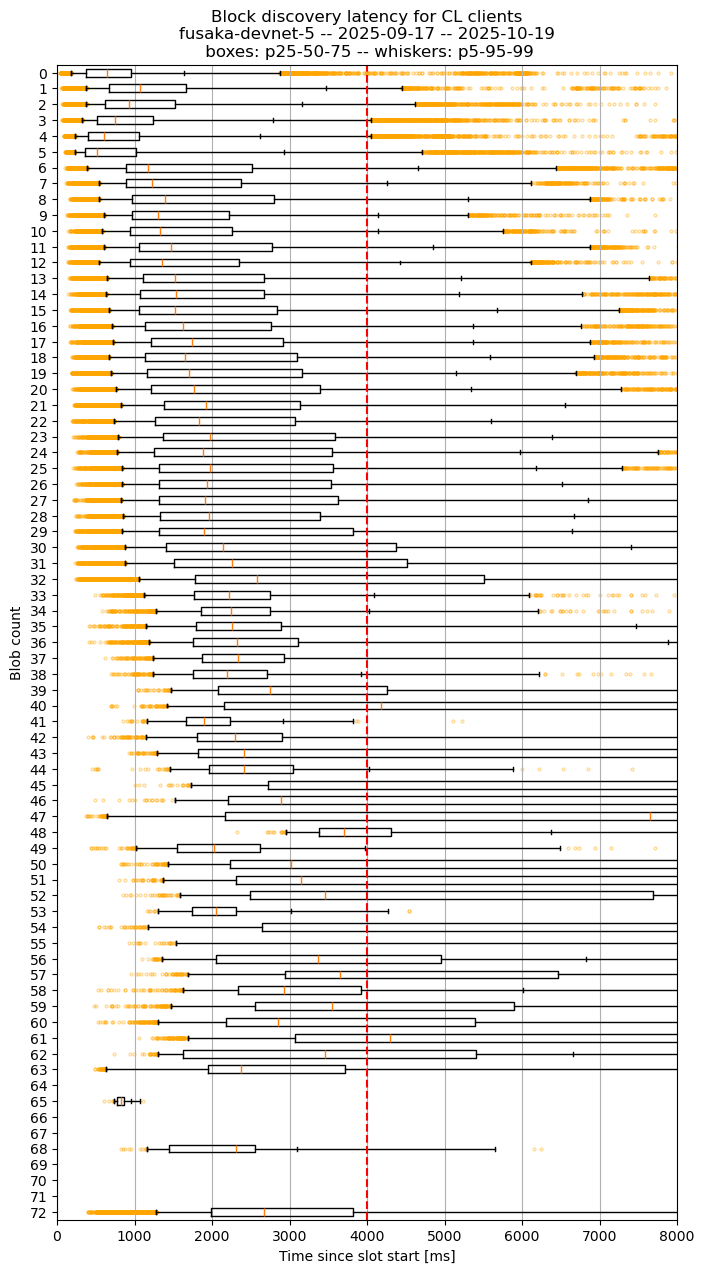

In [8]:
# Filter early by network for speed
network = 'holesky'
if DEVNET5:
    network = 'fusaka-devnet-5'

df_latencies = pd.read_parquet(FILE_LATENCIES)
df_blobs = pd.read_parquet(FILE_BLOBS)

df_latencies = df_latencies[ df_latencies['network'] == network ]
df_blobs = df_blobs[ df_blobs['network'] == network ]

# Merge the two dafaframes to make a link between blobs and block latency
# If the merge results in NaNs, it means no blob data was found so 0 blobs in these blocks
df = pd.merge(df_latencies, df_blobs, on=['network', 'slot'], how='left')
df['blob_count'] = df['blob_count'].fillna(0).astype(np.uint32)
df['total_blob_size'] = df['total_blob_size'].fillna(0).astype(np.uint32)
#print(df)
df_latencies = None
df_blobs = None

# Rearrange the data for easy plotting
data = {}
blobs_min = df['blob_count'].min()
blobs_max = df['blob_count'].max()
for i in range(blobs_min, blobs_max + 1):
    data[i] = df[ df['blob_count'] == i ]['block_latency'].reset_index(drop=True)
    data[i] = data[i].dropna()
    data[i] = data[i].rename(i).rename_axis(i)
df = None
#print(data[10])

figsize = (8, 3)
xlim = 5*1000
filename = f"""blobs-{network}"""
if DEVNET5:
    figsize = (8,15)
    xlim = 8*1000

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Reverse order to have blob 0 at top
columns_order = list(range(blobs_min, blobs_max + 1))[::-1]
boxplot(ax, [data[i] for i in columns_order], showDeadline=True)

ax.set_xlim(0, xlim)

ax.set_xlabel('Time since slot start [ms]')
ax.set_ylabel('Blob count')
ax.set_yticklabels(columns_order)
ax.set_title('Block discovery latency for CL clients'
             + f"""\n{network} -- {QUERY_START_D} -- {QUERY_END_D}"""
             + '\n boxes: p25-50-75 -- whiskers: p5-95-99'
            )

saveFig(filename)
plt.show()
data = None

## Plot: attestation rate vs blob count

Saved figure in fig/attest-fusaka-devnet-5.png


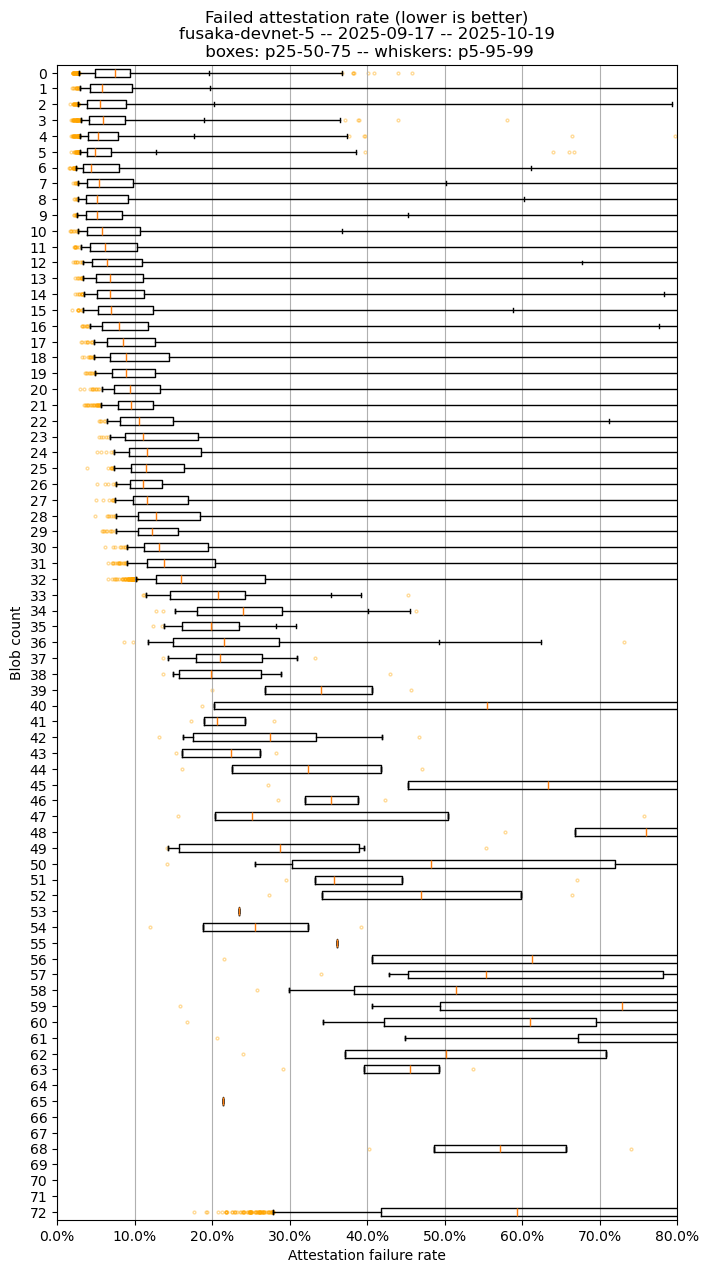

In [9]:
# Filter early by network for speed
network = 'holesky'
if DEVNET5:
    network = 'fusaka-devnet-5'

df_att = pd.read_parquet(FILE_ATTESTATIONS)
df_blobs = pd.read_parquet(FILE_BLOBS)

df_att = df_att[ df_att['network'] == network ]
df_blobs = df_blobs[ df_blobs['network'] == network ]

# Merge the two dafaframes to make a link between blobs and attestations
# If the merge results in NaNs, it means no blob data was found so 0 blobs in these blocks
df = pd.merge(df_att, df_blobs, on=['network', 'slot'], how='left')
df['blob_count'] = df['blob_count'].fillna(0).astype(np.uint32)
df['total_blob_size'] = df['total_blob_size'].fillna(0).astype(np.uint32)
df_att = None
df_blobs = None

# Rearrange the data for easy plotting
data = {}
blobs_min = df['blob_count'].min()
blobs_max = df['blob_count'].max()
for i in range(blobs_min, blobs_max + 1):
    mask = df['blob_count'] == i
    data[i] = 1.0 - df[mask]['attested_validators'] / df[mask]['total_validators']
    data[i] = data[i].reset_index(drop=True).dropna()
    data[i] = data[i].rename(i).rename_axis(i)
df = None
#print(data[)

figsize = (8, 3)
filename = f"""attest-{network}"""
if DEVNET5:
    figsize = (8,15)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Reverse order to have blob 0 at top
columns_order = list(range(blobs_min, blobs_max + 1))[::-1]
boxplot(ax, [data[i] for i in columns_order])

#ax.set_xscale('log')
#ax.set_xlim(0.001, 0.5)
ax.set_xlim(0.0, 0.8)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.1f%%" % (x*100)))

ax.set_xlabel('Attestation failure rate')
ax.set_ylabel('Blob count')
ax.set_yticklabels(columns_order)
ax.set_title('Failed attestation rate (lower is better)'
             + f"""\n{network} -- {QUERY_START_D} -- {QUERY_END_D}"""
             + '\n boxes: p25-50-75 -- whiskers: p5-95-99'
            )

saveFig(filename)
plt.show()
data = None